#Preliminaries

This code is derived from

https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

Miscellaneous references
https://slazebni.cs.illinois.edu/spring17/lec12_vae.pdf



---

The code was originally written on Colab and run on its default GPUs.

If you are running it on some terminal where maybe torchvision isn't installed then execute the following lines first,

```
source /etc/anaconda3/bin/activate
pip install torchvision
anaconda-navigator

```

The above will install torchvision and open the navigator, from which you can select Jupyter and load this file into it - and have fun :)



##Introduction to Conditional Distributions & KL-Divergence


https://www.probabilitycourse.com/chapter1/1_4_0_conditional_probability.php

https://home.ttic.edu/~madhurt/courses/infotheory2021/

# Introduction to VAE



Suppose we have two random variables $\vec{x}$ and $\vec{z}$ (hence there is a joint distribution over them) and consider being given two conditional distributions $q(\vec{z}|\vec{x})$ and $p(\vec{z}|\vec{x})$ both of which are trying to approximate the true conditional distribution of $\vec{z}$ given $\vec{x}$. Then we can compute the KL divergence between the two to try to measure the discrepancy between these two descriptions. Towards that we observe the following analysis of this measure of discrepancy (we do an abuse of notation here to use $\vec{z}$ for denoting two different things - in the LHS its labelling the distributions and in the RHS its indexing all possible samples of it),

\begin{align}
&{\rm KL}(q(\vec{z}|\vec{x})||p(\vec{z}|\vec{x}))\\
&= \sum_{\vec{z}} q(\vec{z}|\vec{x}) \log \frac{q(\vec{z}|\vec{x})}{p(\vec{z}|\vec{x})}\\
&= -\sum_{\vec{z}} q(\vec{z}|\vec{x}) \log \frac{p(\vec{z}|\vec{x})}{q(\vec{z}|\vec{x})}\\
&= -\sum_{\vec{z}} q(\vec{z}|\vec{x})  \left[\log p(\vec{z}|\vec{x}) - \log q(\vec{z}|\vec{x}) \right]\\
&= -\sum_{\vec{z}} q(\vec{z}|\vec{x}) \left[\log \frac{p(\vec{x}|\vec{z})p(\vec{z})}{p(\vec{x})} - \log q(\vec{z}|\vec{x}) \right]\\
&= -\sum_{\vec{z}} q(\vec{z}|\vec{x}) \left[\log p(\vec{x}|\vec{z}) + \log p(\vec{z}) - \log p(\vec{x}) - \log q(\vec{z}|\vec{x}) \right]\\
&= \sum_{\vec{z}} q(\vec{z}|\vec{x}) \left[-\log p(\vec{x}|\vec{z}) - \log p(\vec{z}) + \log p(\vec{x}) + \log q(\vec{z}|\vec{x}) \right]
\end{align}

The above can be written as,  

\begin{align}
\log p(\vec{x}) = &{\rm KL}(q(\vec{z}|\vec{x})||p(\vec{z}|\vec{x})) - \sum_{\vec{z}} q(\vec{z}|\vec{x}) \left[-\log p(\vec{x}|\vec{z}) - \log p(\vec{z}) + \log q(\vec{z}|\vec{x}) \right]\\
= &{\rm KL}(q(\vec{z}|\vec{x})||p(\vec{z}|\vec{x})) + \underbrace{\left[ \mathbb{E}_{q} \log p(\vec{x}|\vec{z})  - \mathbb{E}_{q}  \log \frac{q(\vec{z}|\vec{x})}{p(\vec{z})} \right]}_{\bf ELBO = -V.F.E}\\
\end{align}

>The above argument was done assuming that the $\sum_{\vec{z}}$ makes sense and that necessarily needs a finite number of possible values for the random variable $\vec{z}$. But we shall skip re-writing the above proof for continuous random variables - as needed in this experiment - and shall just assert without proof the veracity of the last equality obtained.

The second term on the LHS is called the "Evidence Lower Bound (ELBO)" -- since because of the non-negativity of the KL (the so-called "variational gap") we can write,

$$ {\rm ELBO} \leq \log p(\vec{x})$$


Since $\log p(\vec{x})$ is a constant, and we want to minimize the ${\rm KL}$ term, we can achieve the same by maximizing the ELBO.
Which is the same as the minimization of its negative i.e the optimization problem that we actually code for is,


$$
\min \Bigg ( \underbrace{\underbrace{- \color{blue}{\mathbb{E}_{q} \log p(\vec{x}|\vec{z})}}_{{\rm ``Reconstruction ~Loss"}}  + \color{red}{ {\rm KL} (  q(\vec{z}|\vec{x}) ||  p(\vec{z})) }}_{``\textbf{Variational Free Energy (V.F.E)}"} \Bigg )
$$


Thus by minimizing the VFE we bring the $p(\vec{z}|\vec{x})$ to be close to the $q(\vec{z}|\vec{x})$ -- thus the process of minimizing the V.F.E. can be seen as an attempt to bring close two different parameterizations of the conditional distribution of $\vec{z}$ given $\vec{x}$. ***We shall see that the two nets to be eventually used essentially play this role of giving these two parameterizations.***

**BUT note that its $p(\vec{x}|\vec{z})$ that occurs in the optimization objective** -- and hence at the end of the training a good $p(\vec{x}|\vec{z})$ will be read off and that in turn reveals the ``unknown" distribution $p(\vec{x})$ via the formula $p(\vec{x}) = \int p(\vec{x}|\vec{z}) p(\vec{z}) d\vec{z}$. **We are very crucially assuming that the last integral here is doable which is what will motivate us to choose simple distributions for $\vec{z}$.**




<!-- We don't want to (cant!) compute the KL divergence analytically, so we'll instead use the Monte Carlo estimate.

$$
\mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} = \mathbb{E}_{q} [\log q(z|x) - \log{p(z)}]
$$ -->





##Objective

> Given samples $\vec{x} \sim p(\vec{x})$ we want to uncover the function $p(\vec{x})$ by minimizing the V.F.E over the three distributions that occur in it - which we recall are given in terms of,

> (a) $p(\vec{x} \vert \vec{z})$, the "posterior distribution" w.r.t $\vec{z}$ the ``fictitious" latent r.v

> (b) $q(\vec{z} \vert \vec{x})$ and

> (c) $p(\vec{z})$ the distribution of the "latent variable"

Setting the above objective is essentially tantamount of assuming that the data $\vec{x}$ are indeed samples of a distribution $p(\vec{x})$ which can be obtained as the marginal of a ***"generative model"*** which is a joint distirbution $p(\vec{x},\vec{z})$ over the data $\vec{x}$ and the latent variable $\vec{z}$. This assumption of the factorization "$p(\vec{z},\vec{x}) = p(\vec{x} \vert \vec{z}) \cdot p(\vec{z})$" of this imagined joint distribution over the data and a fictitious latent variable is a key insight that gets the entire field started.


Towards achieving the aforesaid objective we recall the following fact about Gaussian distribution and note two key ideas.

---
FACTS :  

- Given a $d-$dimensional vector $\vec{\mu}$ and a $d-$dimensional invertible symmetric matrix $\Sigma$, We use the following notation to denote the multi-variable Gaussian distribution's p.d.f.,

$${\cal N}(\vec{\mu},\Sigma) = \frac{1}{\sqrt{(2\pi)^d {\rm det}(\Sigma)}} e^{-\frac{1}{2} (\vec{x}-\vec{\mu})^\top \Sigma^{-1} (\vec{x}-\vec{\mu})}  $$

- If $\vec{X} \sim {\cal N}(\vec{\mu},\Sigma)$ as above, then it is equivalent to assuming that $\vec{a}^\top \vec{X}$ is a one dimensional Gaussian distributed random variable for every vector $\vec{a}$ in $d-$dimensions. This gives a more intutive picture of what multivariate Gaussian distributions look like.

- Recall that if $\vec{X} \sim {\cal N}(\vec{\mu},\Sigma)$ then, $a\vec{X} + \vec{b} \sim {\cal N}(a\vec{\mu} + \vec{b},a^2\Sigma)$

  In particular, $\vec{a}{\cal N}(0,I) + \vec{b} \sim  {\cal N}( \vec{b},{\rm diag}(a^2))$

  -- this particular case shall be needed very soon!


- Recall ([reference ](https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/)) that we have an expression for exact KL diverergence between two Gaussians in the same dimension. If we have two random variables in $k$ dimensions, $f_i \sim {\cal N}(\vec{\mu_i},\Sigma_i)$ for $i=1,2$ then we have,

$${\rm KL}(f_1 || f_2) = \frac{1}{2} \cdot \left [-k + (\vec{\mu_1} - \vec{\mu_2})^\top \Sigma_2^{-1} (\vec{\mu_1} - \vec{\mu_2}) +  \log \frac{\det (\Sigma_2)}{\det (\Sigma_1)} + {\rm Tr} (\Sigma_2^{-1}\Sigma_1) \right ]$$

$$\text{And in particular,}$$

$${\rm KL}({\cal N}(\vec{\mu},\Sigma) || {\cal N}(0,I) ) =  \frac{1}{2} \cdot \left [-k + \Vert{\vec{\mu}}\Vert^2 + {\rm Tr} (\Sigma) - \log {\det (\Sigma)} \right ] $$




---

##Solution Ideas


- The **first key idea** will be exploit the above identity and to model $p(z), p(x \vert z)$ and $q(z | x)$ as Gaussian distributions.


- The **second key idea**, is that we will try to make the Gaussian distribution $q(z |x)$ as expressive as possible by using a neural net (the "Encoder'') to represent its mean and variance and we will have a second neural net (the "Decoder") to represent the mean of $p(x \vert z)$.

In the next subsection we define these two nets.  


##Defining The Nets

Assuming that $x \in \mathbb{R}^{\rm image-dimension}$, we *choose* an appropriate value of ${\rm latent-dimension}$ s.t $z \in \mathbb{R}^{\rm latent-dimension}$. Then the needed pair of nets can be denoted as,  
    

$$ {\rm Encoder}_{\Phi} : \mathbb{R}^{\rm image-dimension} \rightarrow \mathbb{R}^{\rm latent-dimension} \times \mathbb{R}^{\rm latent-dimension} $$

$$ {\rm Decoder}_{\Theta} : \mathbb{R}^{\rm latent-dimension} \rightarrow \mathbb{R}^{\rm image-dimension} $$
      
  In above $\Phi$ and $\Theta$ are to denote the set of all trainable weights in the Encoder and the Decoder respectively. In the particular implementation that will demonstrate here we shall have both these nets be of depth $3$ (and hence each of them will have $3$ affine transforms). The first two activation layers in each would be ${\rm hidden-dimension}$ sized ${\rm Leaky-ReLU}$ activations. The Encoder has 2 layers of activation while the Decoder will be using a third layer of sigmoid activations at the output.

##Parameterizing The Distributions

Given any data sample $\vec{x}$, we define the mean $\vec{\mu}$ and the diagonal variances $\vec{\sigma}$ of the assumed Gaussian, $q(\vec{z}|\vec{x})$ as,

- $q(\vec{z} |\vec{x}) = q_{\Phi}(\vec{z} |\vec{x}) :=  {\cal N}(f({\rm Encoder}_{\Phi} (\vec{x})))$

Where $f$ is a transformation -- that we shall soon specify -- which we shall do to the outputs of the ${\rm Encoder}_\Phi$ to obtain the mean and the variance of the Normal distribution of $q(\vec{z} | \vec{x})$.

Given any sample $\vec{z}$ from $q_{\Phi}(\vec{z} |\vec{x})$, we let the $p$ be more general and only assume that,

- $p(\vec{x} |\vec{z}) = p_{\Theta}(\vec{x} |\vec{z}) := \mathcal{N}({\rm Decoder}_{\Theta}(\vec{z}), {\rm diag(all{-}ones{-}vector)})$

We assume that the distribution of the latent variable is just the standard normal,

- $p(\vec{z}) = {\cal N}(0,I)$



##The V.A.E.

If we can sample $\vec{z_s} \sim q_{\Phi}(\vec{z}|\vec{x}) ~\forall s=1,\ldots,S$  then the  minimization objective -- the "**Variational Free Energy (V.F.E.)**" is replaced by its empirical (Monte Carlo) estimate,

\begin{align*}
{\rm Empirical ~V.F.E.} :=&- \color{blue}{\tilde{\mathbb{E}}_{q_{\Phi}} \log p_{\Theta}(\vec{x}|\vec{z})}  + \color{red}{ \tilde{\mathbb{E}}_{q_{\Phi}} \log \left (  \frac{q_\Phi(\vec{z}|\vec{x})}{p(\vec{z})} \right ) }\\
= & \frac{1}{S} \sum_{s=1}^S \left \{ \underbrace{\color{blue}{- \log p_{\Theta}(\vec{x}|\vec{z_s})}}_{\rm Reconstuction Loss} + \underbrace{\color{red} { \log q_\Phi(\vec{z_s}|\vec{x}) - \log p(\vec{z_s})}}_{\rm KL-Divergence}  \right \}\\
\end{align*}



We note that, ``Variational Autoencoder (VAE)" is not a single architecture but a system which uses 2 neural nets for implementing the plan as said above for learning an unknown marginal distribution of the data $p(x)$ by approximating it as $p_{\Theta} (\vec{x}) := \int p_{\Theta} (\vec{x} | \vec{z}) p(\vec{z})$.

# Packages

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sun Dec 10 23:39:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
#from torchinfosummary import summary (sometimes this works)
from torchsummary import summary
from torch.utils.data import random_split

import numpy as np
import torchvision
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

<ipython-input-2-8b1e08760bfb>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


#Model and Optimization Hyperparameters

You can speed-up this code almost 3x if you run it on Google Colab

--  and change settings as, Runtime ->Change runtime type ->Hardware Accelerator -> GPU

-- and then set cuda=True below.

In [3]:
dataset_path = '~/datasets'

cuda =  True #False
DEVICE = torch.device("cuda" if cuda else "cpu")




x_dim  = 784
#x_dim will be used as the value for the input_dim and output_dim below and it is the same as the image-dimension in the text above
hidden_dim = 1024
latent_dim = 8

lr = 1e-3
epochs = 31
#use number of epoch = something which is 1 + a multiple of 5
# - that keeps it consistent with the fact that the population risk is computed every 5 epochs.
train_size = 10000
#also try 60000
validation_size = 60000 - train_size
batch_size = 10**2
test_batch_size = 10**4

Check versions!

In [4]:
print(torch.__version__)
print(np.__version__)
print(torchvision.__version__)

2.1.0+cu118
1.23.5
0.16.0+cu118


#The Dataset

In [5]:
from torchvision.datasets import MNIST, FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([transforms.ToTensor(),])
#ToTensor converts the  data images to torch tensor
kwargs = {'num_workers': 1, 'pin_memory': True}
#The above is some setting with the GPUs

train_dataset = FashionMNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = FashionMNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

#The above line redefines the train_dataset to use a randomly chosen train_size sized subset of the train_dataset
#Quite obviously using larger train_size should help.
#In this particular demonstration we shall not make use of the validation_dataset that gets produced above.
#Typically performance on the validation_dataset is what is used to determine good choices of achitecture and the step-lengths and the number of epochs.

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=test_batch_size, shuffle=False, **kwargs)

100%|██████████| 26421880/26421880 [00:02<00:00, 10296800.65it/s]


Extracting /root/datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 175981.74it/s]


Extracting /root/datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3245554.57it/s]


Extracting /root/datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6409105.67it/s]

Extracting /root/datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/FashionMNIST/raw



For various future purposes it is important to know that both the data options we work with above consist of 60000 training data and 10000 test data, and all being 28x28 black and white images. These 28x28 pixel values range from 0 to 255 - the smaller numbers closer to zero represent the darker shade while the larger numbers closer to 255 represent the lighter or the white shade.

In [6]:
test_size = len(test_dataset)
print(test_size)

10000


#Defining Our Variational AutoEncoder (VAE)

NOTATION : Any quantity like $A_{\rm some-number}$ or $B_{\rm some-number}$ denotes an affine transformation between appropriate Euclidean spaces.  These are implemented in PyTorch via the keyword ``nn.Linear" - quite a misnomer!!

##Defining The Encoder

In [7]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_layer_1 = nn.Linear(input_dim, hidden_dim)
        self.FC_layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_1      = self.LeakyReLU(self.FC_layer_1(x))
        # R^{image_dim} \ni x -> = LeakyReLU(A_1(x)) = h_1 \in R^{hidden_dim}
        h_2       = self.LeakyReLU(self.FC_layer_2(h_1))
        # R^{hidden_dim} \ni h_1 -> LeakyReLU(A_2(h_1)) = h_2 \in R^{hidden_dim}
        mean     = self.FC_mean(h_2)
        log_var  = self.FC_var(h_2)
        # R^{hidden_dim} \ni h_2 -> (A_31(h_2),A_32(h_2)) = (mean,log_var) \in R^{hidden_dim} x R^{hidden_dim}

        # encoder produces mean and log of variance i.e., parameters of a Gaussian distribution "q"

        return mean, log_var


# So here the Encoder is a depth-3 net mapping R^{input_dim} -> R^{hidden_dim} x R^{hidden_dim} as x -> ( A31( ReLU(A2( ReLU(A1(x)) )) ), A32( ReLU(A2( ReLU(A1(x)) )) ) )

We define the following equivalences betwee the program variables and the mathematical variable,

${\tt input\_dim} = {\rm image-dimension}$

${\tt hidden\_dim} = {\rm hidden-dimension}$

${\tt latent\_dim} = {\rm latent-dimension}$


Then the structure of the encoder defined above motivates the definintion of two sub-networks of the ${\rm Encoder}$ net as ${\rm Enc}_1$ and ${\rm Enc}_2$ to facilitate future description :

\begin{align}
{\rm Encoder} : \mathbb{R}^{\rm image-dimension} \rightarrow &\mathbb{R}^{\rm latent-dimension} \times \mathbb{R}^{\rm latent-dimension} \\
\vec{x} \mapsto &({\rm Enc}_1 (\vec{x}),{\rm Enc}_2 (\vec{x}))
= (A_{31}(\vec{h_2}),A_{32}(\vec{h_2})) = ({\rm mean}, {\rm log-var})\\
&{\tt {\rm where , } ~\mathbb{R}^{\rm hidden-dimension} \ni \vec{h_2} = {\rm ReLU}( A_2 ({\rm ReLU} (A_1(\vec{x}))))}
\end{align}



Recall that any affine transform of the form $A_* : \mathbb{R}^m \rightarrow \mathbb{R}^n$ acts on an input vector $\vec{q}$ as $A_*(\vec{q}) = L_*(\vec{q}) + \vec{b}_*$ where $\vec{b}_* \in \mathbb{R}^n$ and $L_*$ is a $m \times n$ matrix. **Question :** In terms of ${\rm input/output/hidden - dimension}$ count how many trainable parameters does the encoder have?  

## Defining The Decoder

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.FC_dec_layer_1 = nn.Linear(latent_dim, hidden_dim)
        self.FC_dec_layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, z):
        dec_h_1     = self.LeakyReLU(self.FC_dec_layer_1(z))
        # R^{latent_dim} \ni z -> ReLU(B1(z)) = dec_h_1 \in R^{hidden_dim}

        dec_h_2     = self.LeakyReLU(self.FC_dec_layer_2(dec_h_1))
        # R^{hidden_dim} \ni dec_h_1 -> ReLU(B2(dec_h_1)) = dec_h_2 \in R^{hidden_dim}

        x_hat = torch.sigmoid(self.FC_output(dec_h_2))
        #R^{hidden_dim} \ni dec_h_2 -> Sigmoid(B3(dec_h_2)) = x_hat \in R^{output_dim}

        return x_hat


# So here the Decoder is a depth-3 net mapping R^{latent_dim} -> R^{output_dim} as z -> Sigmoid(B3( ReLU(B2( ReLU(B1(z)) )) ))

We further define the following renaming between the program variables and the mathematical variable,

${\tt output\_dim} = {\rm decoder-output-dimension}$




Recall that any affine transform of the form $A_* : \mathbb{R}^m \rightarrow \mathbb{R}^n$ acts on an input vector $\vec{q}$ as $A_*(\vec{q}) = L_*(\vec{q}) + \vec{b}_*$ where $\vec{b}_* \in \mathbb{R}^n$ and $L_*$ is a $m \times n$ matrix. **Question :** In terms of ${\rm input/output/hidden - dimension}$ count how many trainable parameters does the decoder have?

## Combining The Encoder And The Decoder

In [9]:
def reparameterization(mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)
        # sampling epsilon ~ N(0,I_{latent-dimension x latent-dimension})
        y = mean + var*epsilon
        # The so-called "reparameterization trick"
        return y

The above function specifies that $\vec{y}$ is a random variable s.t,
$${\mathbb{R}}^{{\rm latent-dimension}} \ni {\vec y} \sim \vec{ {\rm mean}} + {\rm var} \times {\cal N}(0,I)) \sim {\cal N}(\vec{{\rm mean}}, {\rm diag(var^2)})$$

In [11]:
## Now we define the final model

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()

        self.Encoder = Encoder
        self.Decoder = Decoder


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        y = reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.Decoder(y)

        return x_hat, mean, log_var

NOTE: In here we shall use the $\log$ and the $\exp$ to be acting coordinate-wise when applied to a vector.

For every input (image) vector $\vec{x}$, the ``forward" function above does the following $3$ step computation,  

> STEP-1 : $$ (\vec{\mu_z}, 2\cdot \log(\vec{\sigma_z})) := {\rm Encoder}_{\Phi} (\vec{x})$$

The "reparameterization" function is getting called with ${\tt mean} = \vec{\mu_z}$ and ${\tt var} = \exp({\frac{1}{2} \times 2\cdot \log(\vec{\sigma_z})}) = \vec{\sigma_z} $


And it returns a sample of a random variable s.t,
> STEP-2 : $${\vec z} \sim   {\cal N}(\vec{\mu_z},{\rm diag}(\vec{\sigma_z} \circ \vec{\sigma_z}))$$

(There is a bit of a misnaming here since the word ${\tt var}$ might remind one of "variance" but as is clear from above its actually the ``standard deviation'' of the latent variable. But we shall stick with usual definitions for now.)

Also the above 2 Steps together now effectively specify a choice of the function $f$ that was mentioned in the previous section, "Parameterizing The Distributions"


>STEP-3 : $$\hat{x} = {\rm Decoder}_{\Theta}(\vec{z})$$

Thus for every data $\vec{x}$ the ${\tt forward}$ function returns a $3-$tuple of vectors,
$${\tt (x\_{hat}, mean, log\_var)} :=  (\hat{x},\vec{\mu_z}, 2\cdot \log(\vec{\sigma_z}))$$



**In many usual neural net implementaions the ``forward" function/propagation just computes an output vector after evaluating some neural net at the given input. But in V.A.E. things are much more complicated! Here the forward function implements a "stochastic process'' which uses (two) neural nets, the input data and a source of randomization and computes a set of 3 vectors as given above - of which $\hat{x}$ is a random variable.**

In [12]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)


#(en)/(de)coder is an object of the class (En)/(De)coder
#model is an object of the class Model  - which takes as input entire objects encoder and the decoder

summary(model,(1,x_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]         803,840
         LeakyReLU-2              [-1, 1, 1024]               0
            Linear-3              [-1, 1, 1024]       1,049,600
         LeakyReLU-4              [-1, 1, 1024]               0
            Linear-5                 [-1, 1, 8]           8,200
            Linear-6                 [-1, 1, 8]           8,200
           Encoder-7   [[-1, 1, 8], [-1, 1, 8]]               0
            Linear-8              [-1, 1, 1024]           9,216
         LeakyReLU-9              [-1, 1, 1024]               0
           Linear-10              [-1, 1, 1024]       1,049,600
        LeakyReLU-11              [-1, 1, 1024]               0
           Linear-12               [-1, 1, 784]         803,600
          Decoder-13               [-1, 1, 784]               0
Total params: 3,732,256
Trainable param

The above instantiation of the VAE model crucially forced the following equuality between the different parameters,

${\rm image-dimension} (={\tt input\_dim})= {\rm decoder-output-dimension}(={\tt output\_dim}) = {\tt x\_dim}$

>This forcing of the input to the encoder and the output of the decoder to be the same dimension motivates the terminology of an ``autoencoder" - though **strictly speaking an "autoencoder" refers to a single neural net mapping $\mathbb{R}^k \rightarrow \mathbb{R}^k$ for some $k$ to be an autoencoder**. *V.A.E is not an autoencoder in the same sense* since it is **NOT** representatable as a single function from the input to the encoder to the outoput of the decoder.*





# Defining the Loss Function and the Optimizer

In [13]:
from torch.optim import Adam


# p(x|z) = N(x; x_hat, 1); x_hat = decoder(z)
def loss_function(x, x_hat, mean, log_var):
    MSE_Loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - (log_var).exp())
    # For dim = 1, torch.sum(a_ij, dim=1) = \sum_{j=1}^d a_ij
    # 1 here is an all ones matrix of size (minibatch_size, latent_dimension)
    return MSE_Loss + KLD


#optimizer = Adam(model.parameters(), lr=lr)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.001)

Recall the variable ${\tt batch\_size}$(say $=m$) that was defined earlier. Now we realize that this $m$ is the "mini-batch" size i.e the number of samples of data the eventual algorithm will use to define a stochastic gradient. Further recalling the definition of the ${\rm image-dimension}$ (the input dimension to the encoder) we realize that the function ${\rm loss\_function}$ is designed to get as input as set of $4$ matrices,
- $2$ matrices ${\bf \tt x}, {\bf \tt x\_{\rm hat}} \in \mathbb{R}^{m \times {\rm image-dimension}}$
- $2$ matrices, ${\tt mean, log\_var} \in \mathbb{R}^{m \times {\rm latent-dimension}}$

**Although the above are the right matrix dimensions for how the code operates, for ease of exposition, in what follows we shall treat ${\tt (x\_{hat}, mean, log\_var)}$ as just vectors of appropriate dimensions as would be obtained from a single input data/image data $\vec{x}$**

Towards understanding the above loss function computation recall the identification that we had established between the theoretical variables and the code variables, *(Recall that here $\log$ and $\exp$ applied to any vector shall be seen as being a shorthand for element-wise application)*


$${\tt (x\_{hat}, mean, log\_var)} :=  (\hat{x},\vec{\mu_z}, 2\cdot \log(\vec{\sigma_z}))$$


First we recall that we had defined, $p_{\Theta}(\vec{x} |\vec{z}) := \mathcal{N}({\rm Decoder}_{\Theta}(\vec{z}), {\rm diag(all{-}ones{-}vector)})$.Hence on any one input data $\vec{x}$ the ''Reconstruction Loss'' part of the Variational Free Energy is,
In above one is computing,

> First Term of V.F.E. =  
 $$ {\rm Reconstruction-Loss}(\vec{x}) = -\log p_{\Theta}(\vec{x}|\vec{z}) = \frac{1}{2}||{\vec{x}-{\rm Decoder}_{\Theta}(\vec{z})}||_2^2 = \frac{1}{2}||\vec{x}- \hat{x}||_2^2 $$

In above we have recalled the definition of $\hat{x}$ from the definition of the ``forward" function.  Further recall, that we had defined, $p(\vec{x} |\vec{z}) = p_{\Theta}(\vec{x} |\vec{z}) := \mathcal{N}({\rm Decoder}_{\Theta}(\vec{z}), {\rm diag(all{-}ones{-}vector)})$ -- which implies that there should have been a second term in the above ${\rm Reconstruction-Loss}$ coming from the normalization constant in $\mathcal{N}({\rm Decoder}_{\Theta}(\vec{z}), {\rm diag(all{-}ones{-}vector)})$ - but we shall ignore it since its a constant and that doesnt affect the gradients that would get taken w.r.t the neural weights.

Now let's recall the KL formula we had seen earlier,

$${\rm KL}({\cal N}(\vec{\mu},\Sigma) || {\cal N}(0,I) ) =  \frac{-1}{2} \cdot \left [k + \log {\det (\Sigma)} - \Vert{\vec{\mu}}\Vert^2 - {\rm Tr} (\Sigma) \right ] $$

This we need to invoke  for,

$$ {\rm KL} (q_{\Phi}(\vec{z} |\vec{x}) \Vert p(\vec{z}) ) = {\rm KL} ({\cal N}(f({\rm Encoder}_{\Phi} (\vec{x}))) \Vert {\cal N}(0,I) )$$

where, we recall that, ${\cal N}(f({\rm Encoder}_{\Phi} (\vec{x}))) = {\cal N}(\vec{\mu_z},\Sigma)$ with  $\Sigma = {\rm diag}(\vec{\sigma_z} \circ \vec{\sigma_z}) (= {\rm diag} (e^{{\tt log\_var}} ))$ and thus we have,

> Second Term of V.F.E. =
$${\rm KL} (q_{\Phi}(\vec{z} |\vec{x}) \Vert p(\vec{z}) ) = -\frac{1}{2} \cdot \sum_{i=1}^{\rm latent-dimension} \left [  1 +  ({\rm log\_var}_i) - {\rm mean}_i^2 - e^{ {\tt log\_var_i}}   \right ]$$


Thus the loss being computed at data $\vec{x}$ is,

\begin{align}
&-\log p_{\Theta}(\vec{x}|\vec{z})  + {\rm KL} (q_{\Phi}(\vec{z} |\vec{x}) \Vert p(\vec{z}) )\\
&= \frac{1}{2}||\vec{x}- \hat{x}||_2^2 -\frac{1}{2} \cdot \sum_{i=1}^{\rm latent-dimension} \left [  1 +  ({\rm log\_var}_i) - {\rm mean}_i^2 - e^{ {\tt log\_var_i}}   \right ]
\end{align}

# Training The VAE

Takes 12 minutes without GPU on standard (F)MNIST at the following (most tested) settings :

batch_size = 100,
hidden_dim = 400,
latent_dim = 200,
lr = 1e-3,
epochs = 20

In [14]:
print("The VAE training starts.")
model.train()
Training_Loss = []
Risk = []
Epoch = []
Risk_Epoch = []

for epoch in range(epochs):
    # At the beginning of each epoch we calculate the training and the test loss.
    training_loss = 0
    for batch_number, (r, _) in enumerate(train_loader):
            r = r.view(batch_size, x_dim)
            r = r.to(DEVICE)
            r_hat, mean, log_var = model(r)
            mini_batch_loss = loss_function(r, r_hat, mean, log_var)
            training_loss += mini_batch_loss.item()
            #mini_batch_loss.item() = training loss on the current mini-batch
            #training_loss is accumulating the mini-batch losses to compute the loss on the entire training data.

    Training_Loss.append(training_loss/(train_size))
    #Now we compute the test loss at the same model parameters at which the above training loss was calculated.
    if  epoch%5 == 0:
        test_loss = 0
        for test_batch_number, (t, _) in enumerate(test_loader):
                t = t.view(test_batch_size, x_dim)
                t = t.to(DEVICE)
                t_hat, mean, log_var = model(t)
                mini_batch_loss = loss_function(t, t_hat, mean, log_var)
                test_loss += mini_batch_loss.item()

        Risk.append(test_loss/(test_size))
        Risk_Epoch.append(epoch+1)

    for batch_number, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        #(x,_) pulls out a mini-batch from the train_loader which has now been converted into an enumeratable data type
        #There is some ancilliary information attached to each mini-batch which we dont care about and that is held in that "_"
        #batch_number adds 1 to itself everytime a mini-batch is pulled out
        #Thus the batch_number counts the number of mini-batches in the training data - a number we did not know till now.

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        mini_batch_loss = loss_function(x, x_hat, mean, log_var)
        mini_batch_loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!")

    Epoch.append(epoch+1)


print("The VAE training is over!")


The VAE training starts.
	Epoch 1 complete!
	Epoch 2 complete!
	Epoch 3 complete!
	Epoch 4 complete!
	Epoch 5 complete!
	Epoch 6 complete!
	Epoch 7 complete!
	Epoch 8 complete!
	Epoch 9 complete!
	Epoch 10 complete!
	Epoch 11 complete!
	Epoch 12 complete!
	Epoch 13 complete!
	Epoch 14 complete!
	Epoch 15 complete!
	Epoch 16 complete!
	Epoch 17 complete!
	Epoch 18 complete!
	Epoch 19 complete!
	Epoch 20 complete!
	Epoch 21 complete!
	Epoch 22 complete!
	Epoch 23 complete!
	Epoch 24 complete!
	Epoch 25 complete!
	Epoch 26 complete!
	Epoch 27 complete!
	Epoch 28 complete!
	Epoch 29 complete!
	Epoch 30 complete!
	Epoch 31 complete!
The VAE training is over!


## Understanding the Dynamics of the Training Loss & the Population Risk

Text(0.5, 0, 'epoch')

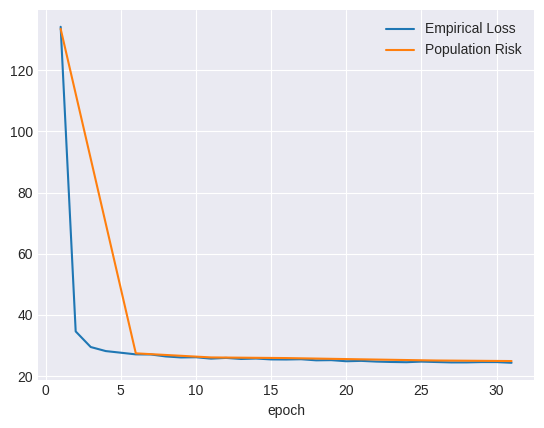

In [15]:
train, = plt.plot(Epoch, Training_Loss, label=("Empirical Loss"))
test, = plt.plot(Risk_Epoch, Risk, label= ("Population Risk"))
plt.legend(handles=[train, test])

plt.xlabel('epoch')

In [16]:
print ("Number of Training Batches =",batch_number+1," & Number of Test Batches =",test_batch_number+1)
print ("Mini-Batch Size =",batch_size)

Number of Training Batches = 100  & Number of Test Batches = 1
Mini-Batch Size = 100


# The Trained "model" Can Map The Test Data to Itself - Almost!

In [17]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(test_batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)

        break


def show_image(x, idx):
    x = x.view(test_batch_size, 28, 28)
    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

  0%|          | 0/1 [00:01<?, ?it/s]


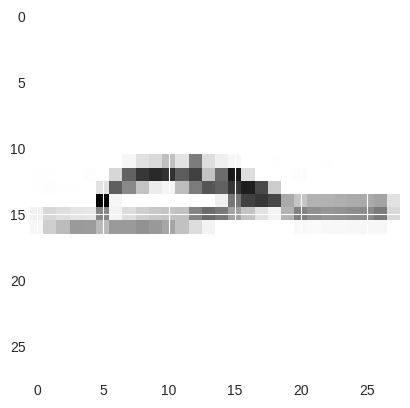

In [18]:
show_image(x, idx=8)

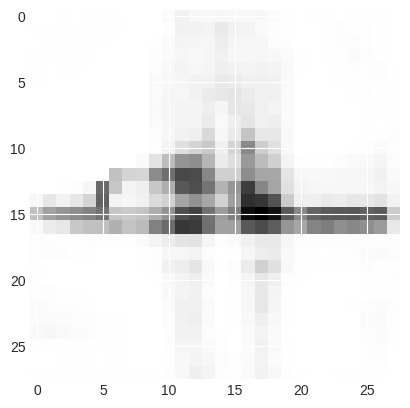

In [19]:
show_image(x_hat, idx=8)

Recall that the later of the 2 images ${\tt x\_hat}$($\tt idx$ element of it) is the output when the VAE gets the fist image ${\tt x}$($\tt idx$ element of it) as input.

Thus the two images being close implies that the VAE was able to almost successfully reconstruct its input - as it was needed to do!

Also note that the above test was run on test data - thats unseen data for the training - and hence this is testing **``generalizability"**

--  i.e whether the VAE is doing the good reconstructions on new data that it was not trained on.

# Trained Decoder Generates Images From Pure Noise!

We note that the trained decoder can map random Gaussian noise samples to meaningful images!

In [20]:
with torch.no_grad():
    noise = torch.randn(test_batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

save_image(generated_images.view(test_batch_size, 1, 28, 28), 'generated_sample.png')

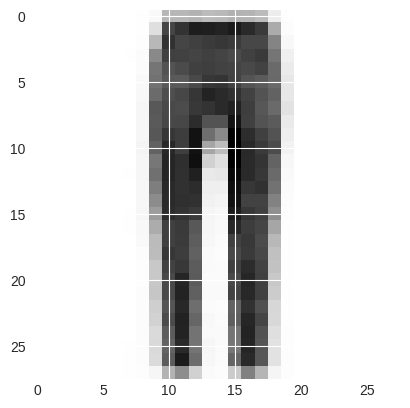

In [21]:
show_image(generated_images, idx=12)

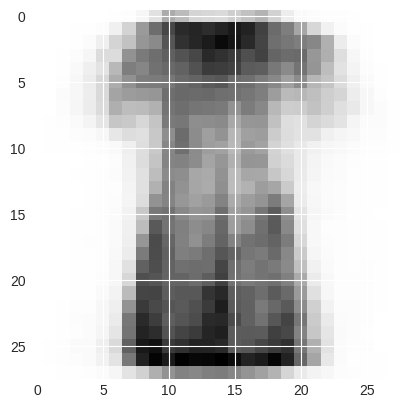

In [22]:
show_image(generated_images, idx=0)

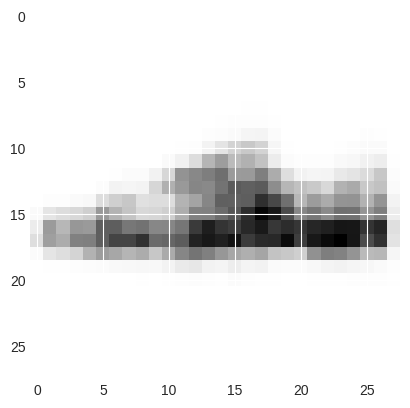

In [23]:
show_image(generated_images, idx=1)

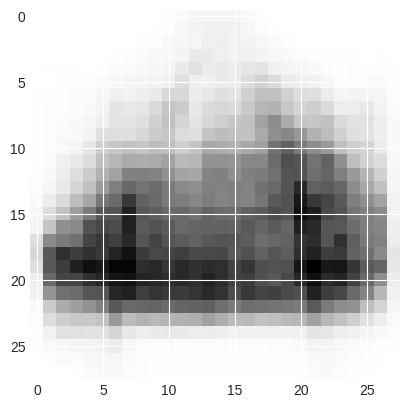

In [24]:
show_image(generated_images, idx=10)

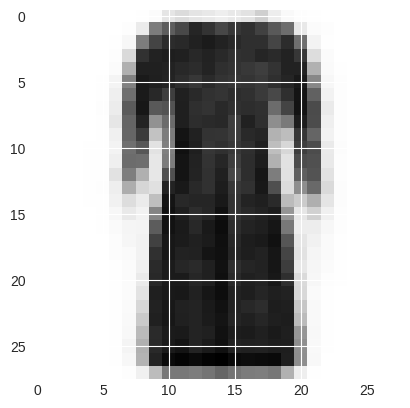

In [25]:
show_image(generated_images, idx=20)

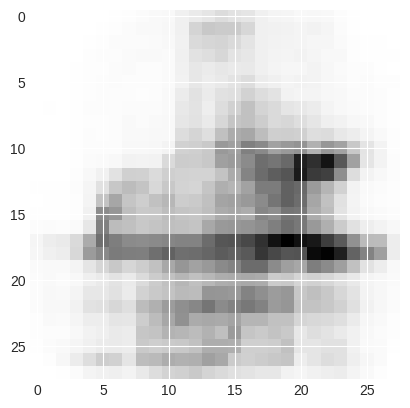

In [ ]:
show_image(generated_images, idx=50)

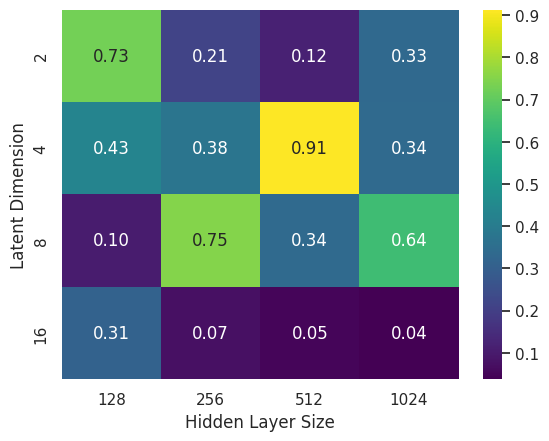

In [37]:
import seaborn as sns

# Sample data (replace this with your actual data)
rows = 4
cols = 4
data = np.random.rand(rows, cols)

# Hidden layer sizes and latent dimensions
hidden_layer_sizes = [2**7, 2**8, 2**9, 2**10]
latent_dimensions = [2**1, 2**2, 2**3, 2**4]

# Create a heatmap using Seaborn
sns.set()  # Set Seaborn style
ax = sns.heatmap(data, annot=True, fmt=".2f", cmap='viridis', xticklabels=hidden_layer_sizes, yticklabels=latent_dimensions)

# Add labels to the axes
ax.set_xlabel('Hidden Layer Size')
ax.set_ylabel('Latent Dimension')

# Display the heatmap
plt.show()

In [27]:
data.shape

(4, 4)

In [38]:
hidden_dims = [5,50,200,500 ] # [2**7,2**8,2**9,2**10]
latent_dims = [5,10,100,300] # [2**1,2**2,2**3,2**4,2**5,2**6,2**7,2**8]

VFE_Values = []

for hd in hidden_dims:
  for ld in latent_dims:
    encoder = Encoder(input_dim=x_dim, hidden_dim=hd, latent_dim=ld)
    decoder = Decoder(latent_dim=ld, hidden_dim = hd, output_dim = x_dim)

    model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.001)

    print("The VAE training starts.")
    model.train()
    Training_Loss = []
    Risk = []
    Epoch = []
    Risk_Epoch = []

    for epoch in range(15):
        # At the beginning of each epoch we calculate the training and the test loss.
        training_loss = 0
        for batch_number, (r, _) in enumerate(train_loader):
                r = r.view(batch_size, x_dim)
                r = r.to(DEVICE)
                r_hat, mean, log_var = model(r)
                mini_batch_loss = loss_function(r, r_hat, mean, log_var)
                training_loss += mini_batch_loss.item()
                #mini_batch_loss.item() = training loss on the current mini-batch
                #training_loss is accumulating the mini-batch losses to compute the loss on the entire training data.

        Training_Loss.append(training_loss/(train_size))
        #Now we compute the test loss at the same model parameters at which the above training loss was calculated.
        if  epoch%5 == 0:
            test_loss = 0
            for test_batch_number, (t, _) in enumerate(test_loader):
                    t = t.view(test_batch_size, x_dim)
                    t = t.to(DEVICE)
                    t_hat, mean, log_var = model(t)
                    mini_batch_loss = loss_function(t, t_hat, mean, log_var)
                    test_loss += mini_batch_loss.item()

            Risk.append(test_loss/(test_size))
            Risk_Epoch.append(epoch+1)

        for batch_number, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(DEVICE)

            #(x,_) pulls out a mini-batch from the train_loader which has now been converted into an enumeratable data type
            #There is some ancilliary information attached to each mini-batch which we dont care about and that is held in that "_"
            #batch_number adds 1 to itself everytime a mini-batch is pulled out
            #Thus the batch_number counts the number of mini-batches in the training data - a number we did not know till now.

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            mini_batch_loss = loss_function(x, x_hat, mean, log_var)
            mini_batch_loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "complete!")

        Epoch.append(epoch+1)


    print("The VAE training is over!")
    print("For hd: ", hd, " ld: ", ld, " vfe: ", Training_Loss[-1])
    VFE_Values.append(Training_Loss[-1])



The VAE training starts.
	Epoch 1 complete!
	Epoch 2 complete!
	Epoch 3 complete!
	Epoch 4 complete!
	Epoch 5 complete!
	Epoch 6 complete!
	Epoch 7 complete!
	Epoch 8 complete!
	Epoch 9 complete!
	Epoch 10 complete!
	Epoch 11 complete!
	Epoch 12 complete!
	Epoch 13 complete!
	Epoch 14 complete!
	Epoch 15 complete!
The VAE training is over!
For hd:  5  ld:  5  vfe:  44.618915063476564
The VAE training starts.
	Epoch 1 complete!
	Epoch 2 complete!
	Epoch 3 complete!
	Epoch 4 complete!
	Epoch 5 complete!
	Epoch 6 complete!
	Epoch 7 complete!
	Epoch 8 complete!
	Epoch 9 complete!
	Epoch 10 complete!
	Epoch 11 complete!
	Epoch 12 complete!
	Epoch 13 complete!
	Epoch 14 complete!
	Epoch 15 complete!
The VAE training is over!
For hd:  5  ld:  10  vfe:  57.15346342773437
The VAE training starts.
	Epoch 1 complete!
	Epoch 2 complete!
	Epoch 3 complete!
	Epoch 4 complete!
	Epoch 5 complete!
	Epoch 6 complete!
	Epoch 7 complete!
	Epoch 8 complete!
	Epoch 9 complete!
	Epoch 10 complete!
	Epoch 11 

In [79]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

4494608


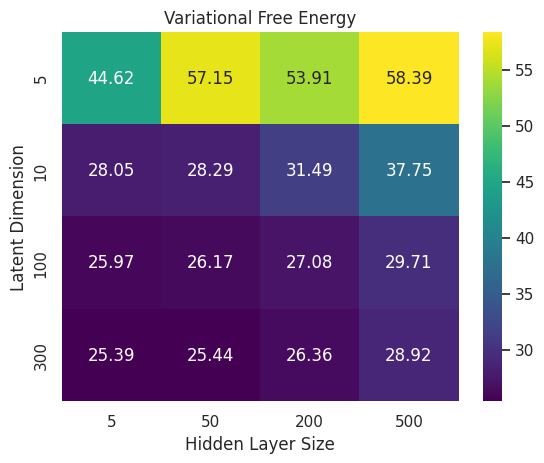

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Provided data
vfe_values = [
    44.618915063476564, 57.15346342773437, 53.911896875, 58.387684375,
    28.04723623046875, 28.28724689941406, 31.487113891601563, 37.74558308105469,
    25.97206513671875, 26.168741479492187, 27.083050732421874, 29.70946418457031,
    25.385903173828126, 25.438307763671876, 26.36254641113281, 28.916988403320314
]
hidden_dims = [5, 50, 200, 500]
latent_dims = [5, 10, 100, 300]

# Reshape vfe_values into a 2D array (matrix) for the heatmap
vfe_values_matrix = np.array(vfe_values).reshape(len(latent_dims), len(hidden_dims))

# Create a heatmap using Seaborn
sns.set()  # Set Seaborn style
ax = sns.heatmap(vfe_values_matrix, annot=True, cmap='viridis', fmt=".2f", xticklabels=hidden_dims, yticklabels=latent_dims)

# Add labels to the axes
ax.set_xlabel('Hidden Layer Size')
ax.set_ylabel('Latent Dimension')

# Display the heatmap
plt.title('Variational Free Energy')
plt.show()


In [72]:
VFE_Values

[44.618915063476564,
 57.15346342773437,
 53.911896875,
 58.387684375,
 28.04723623046875,
 28.28724689941406,
 31.487113891601563,
 37.74558308105469,
 25.97206513671875,
 26.168741479492187,
 27.083050732421874,
 29.70946418457031,
 25.385903173828126,
 25.438307763671876,
 26.36254641113281,
 28.916988403320314]

In [51]:
hidden_dims = [2**7,2**8,2**9,2**10]
latent_dims = [2**1,2**2,2**3,2**4,2**5,2**6,2**7,2**8]
VFE_Values2 = []

for hd in hidden_dims:
  for ld in latent_dims:
    encoder = Encoder(input_dim=x_dim, hidden_dim=hd, latent_dim=ld)
    decoder = Decoder(latent_dim=ld, hidden_dim = hd, output_dim = x_dim)

    model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.001)

    print("The VAE training starts.")
    model.train()
    Training_Loss = []
    Risk = []
    Epoch = []
    Risk_Epoch = []

    for epoch in range(15):
        # At the beginning of each epoch we calculate the training and the test loss.
        training_loss = 0
        for batch_number, (r, _) in enumerate(train_loader):
                r = r.view(batch_size, x_dim)
                r = r.to(DEVICE)
                r_hat, mean, log_var = model(r)
                mini_batch_loss = loss_function(r, r_hat, mean, log_var)
                training_loss += mini_batch_loss.item()
                #mini_batch_loss.item() = training loss on the current mini-batch
                #training_loss is accumulating the mini-batch losses to compute the loss on the entire training data.

        Training_Loss.append(training_loss/(train_size))
        #Now we compute the test loss at the same model parameters at which the above training loss was calculated.
        if  epoch%5 == 0:
            test_loss = 0
            for test_batch_number, (t, _) in enumerate(test_loader):
                    t = t.view(test_batch_size, x_dim)
                    t = t.to(DEVICE)
                    t_hat, mean, log_var = model(t)
                    mini_batch_loss = loss_function(t, t_hat, mean, log_var)
                    test_loss += mini_batch_loss.item()

            Risk.append(test_loss/(test_size))
            Risk_Epoch.append(epoch+1)

        for batch_number, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(DEVICE)

            #(x,_) pulls out a mini-batch from the train_loader which has now been converted into an enumeratable data type
            #There is some ancilliary information attached to each mini-batch which we dont care about and that is held in that "_"
            #batch_number adds 1 to itself everytime a mini-batch is pulled out
            #Thus the batch_number counts the number of mini-batches in the training data - a number we did not know till now.

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            mini_batch_loss = loss_function(x, x_hat, mean, log_var)
            mini_batch_loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "complete!")

        Epoch.append(epoch+1)


    print("The VAE training is over!")
    print("For hd: ", hd, " ld: ", ld, " vfe: ", Training_Loss[-1])
    VFE_Values2.append(Training_Loss[-1])



The VAE training starts.
	Epoch 1 complete!
	Epoch 2 complete!
	Epoch 3 complete!
	Epoch 4 complete!
	Epoch 5 complete!
	Epoch 6 complete!
	Epoch 7 complete!
	Epoch 8 complete!
	Epoch 9 complete!
	Epoch 10 complete!
	Epoch 11 complete!
	Epoch 12 complete!
	Epoch 13 complete!
	Epoch 14 complete!
	Epoch 15 complete!
The VAE training is over!
For hd:  128  ld:  2  vfe:  30.76669833984375
The VAE training starts.
	Epoch 1 complete!
	Epoch 2 complete!
	Epoch 3 complete!
	Epoch 4 complete!
	Epoch 5 complete!
	Epoch 6 complete!
	Epoch 7 complete!
	Epoch 8 complete!
	Epoch 9 complete!
	Epoch 10 complete!
	Epoch 11 complete!
	Epoch 12 complete!
	Epoch 13 complete!
	Epoch 14 complete!
	Epoch 15 complete!
The VAE training is over!
For hd:  128  ld:  4  vfe:  26.259691162109377
The VAE training starts.
	Epoch 1 complete!
	Epoch 2 complete!
	Epoch 3 complete!
	Epoch 4 complete!
	Epoch 5 complete!
	Epoch 6 complete!
	Epoch 7 complete!
	Epoch 8 complete!
	Epoch 9 complete!
	Epoch 10 complete!
	Epoch 

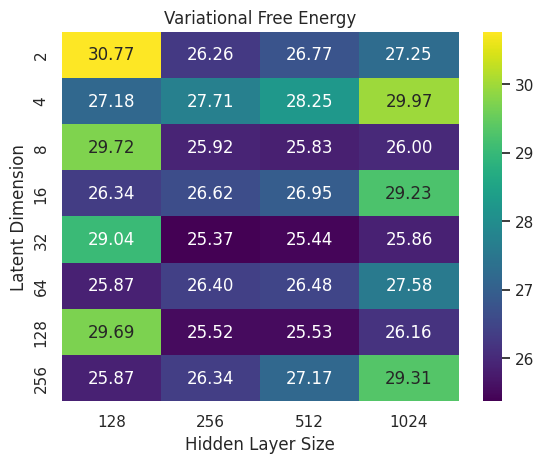

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Provided data
vfe_values2 = [
    30.76669833984375, 26.259691162109377, 26.770762719726562, 27.24945302734375,
    27.1805076171875, 27.707101928710937, 28.246125756835937, 29.96752595214844,
    29.722084887695313, 25.916897534179686, 25.83416281738281, 25.997028515625,
    26.33784697265625, 26.621896020507812, 26.946600610351563, 29.23333798828125,
    29.035656494140625, 25.369221557617188, 25.438552490234375, 25.864128051757813,
    25.868237646484374, 26.397039819335937, 26.47972434082031, 27.57974343261719,
    29.694510107421873, 25.5233359375, 25.527147534179687, 26.159278051757813,
    25.867763940429686, 26.341833911132813, 27.166663720703124, 29.31478024902344
]
hidden_dims = [2**7, 2**8, 2**9, 2**10]
latent_dims = [2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8]

# Reshape vfe_values2 into a 2D array (matrix) for the heatmap
vfe_values_matrix = np.array(vfe_values2).reshape(len(latent_dims), len(hidden_dims))

# Create a heatmap using Seaborn
sns.set()  # Set Seaborn style
ax = sns.heatmap(vfe_values_matrix, annot=True, cmap='viridis', fmt=".2f", xticklabels=hidden_dims, yticklabels=latent_dims)

# Add labels to the axes
ax.set_xlabel('Hidden Layer Size')
ax.set_ylabel('Latent Dimension')

# Display the heatmap
plt.title('Variational Free Energy')
plt.show()


The experiment done in Question 4 can be re-interpreted as having recorded the values of the best test variational free energy obtained at different total numbers of parameters.
Note that the total number of parameters being counted by the "summary" command adds up the total number of trainable parameters in the encoder as well as the decoder.

Q:
Submit a properly labelled plot of the test variational free energy obtained in Question 4 vs the sizes of the architectures/total number of parameters trained.
Have a vertical line drawn at that point on the x-axis which corresponds to the total size of the training data.
Make sure you have a couple of models tried on each side of that vertical line.
Feel free to add in new experiments to satisfy this criterion if the experiments already chosen in Question 4 do not satisfy this.

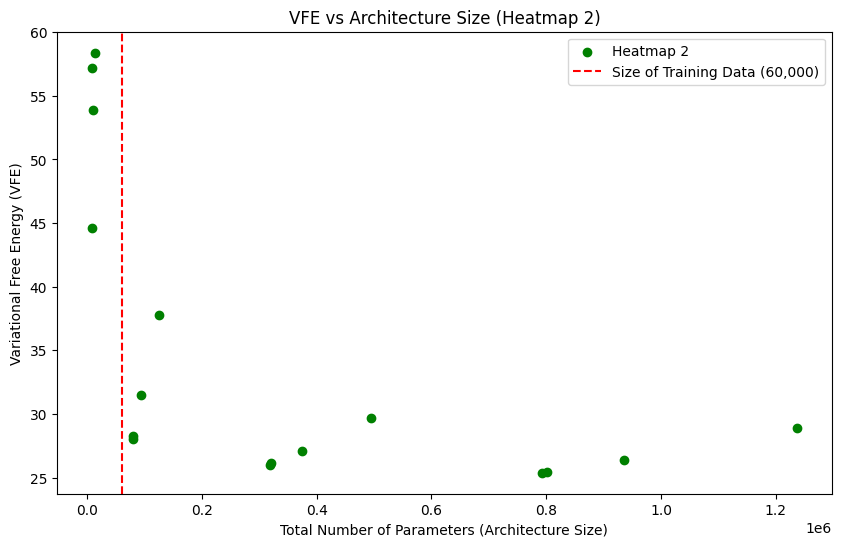

In [1]:
import matplotlib.pyplot as plt

# Sample calculation for total number of parameters (replace with your actual calculation)
# Assuming simple fully connected layers for both encoder and decoder
def calculate_params(input_dim, hidden_dim, latent_dim):
    # Encoder: input to hidden, hidden to latent (mean and log_var)
    encoder_params = (input_dim * hidden_dim) + hidden_dim + (hidden_dim * latent_dim) + latent_dim + (hidden_dim * latent_dim) + latent_dim
    # Decoder: latent to hidden, hidden to output
    decoder_params = (latent_dim * hidden_dim) + hidden_dim + (hidden_dim * input_dim) + input_dim
    return encoder_params + decoder_params

# Data from your experiments
test_losses = {(5, 5): [44.618915063476564], (5, 10): [57.15346342773437], (5, 100): [53.911896875], (5, 300): [58.387684375], (50, 5): [28.04723623046875], (50, 10): [28.28724689941406], (50, 100): [31.487113891601563], (50, 300): [37.74558308105469], (200, 5): [25.97206513671875], (200, 10): [26.168741479492187], (200, 100): [27.083050732421874], (200, 300): [29.70946418457031], (500, 5): [25.385903173828126], (500, 10): [25.438307763671876], (500, 100): [26.36254641113281], (500, 300): [28.916988403320314]}

# Lists to store total parameters and corresponding test losses
total_params = []
test_variational_free_energy = []

for (hidden_dim, latent_dim), loss in test_losses.items():
    params = calculate_params(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim) # x_dim is 784 for MNIST
    total_params.append(params)
    test_variational_free_energy.append(loss)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(total_params, test_variational_free_energy, color='green',  label='Heatmap 2')
plt.axvline(x=60000, color='red', linestyle='--', label='Size of Training Data (60,000)') # Assuming MNIST with 60,000 training samples
plt.xlabel('Total Number of Parameters (Architecture Size)')
plt.ylabel('Variational Free Energy (VFE)')
plt.title('VFE vs Architecture Size (Heatmap 2)')
plt.legend()
plt.show()